In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import entropy
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min
import gc
import time
import os

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
os.environ["WANDB_DISABLED"] = "true"

In [4]:
!pip install realtabformer transformers==4.24.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 7.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of realtabformer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB

In [5]:
from google.colab import drive
import pandas as pd
from realtabformer import REaLTabFormer
from sklearn.utils import resample
import transformers
import re
import traceback

In [6]:
import transformers
print(transformers.__version__)

4.24.0


Prepare July Data

In [7]:
dfjuly = pd.read_csv("df_julyweek5.csv")
dfjuly.head()
dforiginal=dfjuly.copy()

,Date,Duration,Src_Port,Dest_Port,Protocol,TOS,Packets,Bytes,Label,U,A,P,R,S,F
0,2016-07-28 00:51:51,0.000,52771,9594,6,0,1,44,scan44,0,0,0,0,1,0
1,2016-07-28 00:50:18,0.000,49175,38412,6,0,1,40,scan44,0,1,0,1,0,0
2,2016-07-27 13:59:02,0.000,33168,80,6,0,1,52,background,0,1,0,0,0,1
3,2016-07-28 00:51:19,0.000,47828,5414,6,0,1,44,scan44,0,0,0,0,1,0
4,2016-07-27 17:14:28,0.708,56698,25,6,0,6,440,anomaly-spam,0,1,1,1,1,0


In [8]:
def map_classes(label):
    label = label.lower()
    if label.startswith('background'):
        return 0
    elif label.startswith('dos'):
        return 1
    elif label.startswith('nerisbotnet'):
        return 2
    elif label.startswith('scan44'):
        return 3
    elif label.startswith('anomaly-spam'):
        return 4

# Apply the mapping function to the 'Label' column
dfjuly['Class'] = dfjuly['Label'].apply(map_classes)
dfjuly['Class'] = dfjuly['Class'].astype(int)

In [9]:
def map_labels(label):
    label = label.lower()
    if label.startswith('background'):
        return 'Benign'
    elif label.startswith('dos'):
        return 'DoS'
    elif label.startswith('nerisbotnet'):
        return 'Botnet'
    elif label.startswith('scan44'):
        return 'Scan44'
    elif label.startswith('anomaly-spam'):
        return 'Spam'

# Apply the mapping function to the 'Label' column
dfjuly['Label'] = dfjuly['Label'].apply(map_labels)

In [10]:
dfjuly.Label.value_counts()

,count
Label,
Benign,30000
Scan44,17500
Spam,17500
Botnet,17500
DoS,17500


In [11]:
print(dfjuly.columns)

Index(['Date', 'Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS',
       'Packets', 'Bytes', 'Label', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [12]:
dfbefore=dfjuly.copy()

In [13]:
#reduce samples of minority class
spam_reduced_july = dfjuly[dfjuly.Label == "Spam"].sample(n=2000, random_state=42)
botnet_reduced_july = dfjuly[dfjuly.Label== "Botnet"].sample(n=2000, random_state=42)
# dos_reduced_july = dfjuly[dfjuly.Label == "DoS"].sample(n=2000, random_state=42)
# scan44_reduced_july = dfjuly[dfjuly.Label == "Scan44"].sample(n=2000, random_state=42)
dfjuly = dfjuly[~dfjuly.Label.isin(["Spam", "Botnet"])]
dfjuly= pd.concat([spam_reduced_july, botnet_reduced_july, dfjuly])
dfjuly.Label.value_counts()

,count
Label,
Benign,30000
DoS,17500
Scan44,17500
Spam,2000
Botnet,2000


In [14]:
dfjuly.Label.value_counts()

,count
Label,
Benign,30000
DoS,17500
Scan44,17500
Spam,2000
Botnet,2000


In [15]:
dfjuly = dfjuly.drop(columns=['Date', 'Label'])

In [16]:
dfjuly.Class.value_counts()

,count
Class,
0,30000
1,17500
3,17500
4,2000
2,2000


In [17]:
print(dfjuly.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [18]:
dforiginal=dfjuly.copy()

In [19]:
botnet_orig = dfjuly[dfjuly.Class == 2]
spam_orig = dfjuly[dfjuly.Class == 4]
# dos_orig= dfjuly[dfjuly.Class == 1]
# scan44_orig= dfjuly[dfjuly.Class == 3]

Split Train/Test

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
# Define MLP classifier
clf_name_mlp = 'MLP'
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=2000, early_stopping=True)

# Define SVM classifier
clf_name_svm = 'SVM'
svm_classifier = SVC(class_weight='balanced', kernel='rbf', C=0.1, probability=True,random_state=42)

In [21]:
print(dfjuly.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [22]:
# fit algorithm to data
def fit_algo(algo, train_x, train_y):

    model = algo.fit(train_x, train_y)
    gc.collect()
    return model

def train_and_test(clf_name, clf, results, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model = fit_algo(clf, X_train, y_train)
    train_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    f1 = f1_score(y_test, y_pred, average=None)
    f1_avg = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate FPR and FNR for each class
    class_fpr = []
    class_fnr = []

    for i in range(conf_matrix.shape[0]):
        tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))  # sum of all non-i cells
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]  # sum of i-th column, excluding diagonal
        fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]  # sum of i-th row, excluding diagonal
        tp = conf_matrix[i, i]  # i-th diagonal element

        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Avoid division by zero
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0  # Avoid division by zero

        class_fpr.append(fpr)
        class_fnr.append(fnr)

    # Overall FPR and FNR (averaging across classes)
    avg_fpr = np.mean(class_fpr)
    avg_fnr = np.mean(class_fnr)

    return f1, f1_avg, train_time, conf_matrix, class_fpr, class_fnr, avg_fpr, avg_fnr

def preprocess_data(df):
    df_copy = df.copy()

    X = df_copy.drop('Class', axis=1)
    y = df_copy['Class']

    X = X.apply(pd.to_numeric, errors='coerce')

    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(X.mean(), inplace=True)

    # Double-check that no NaN values remain
    if X.isnull().any().any():
        print("Warning: NaNs detected in data after preprocessing. Check data sources or methods.")
        X.fillna(0, inplace=True)  # Fallback option: replace any remaining NaNs with 0

    return X.values, y.values

# Preprocess data
X_july, y_july = preprocess_data(dfjuly)


In [23]:
print(dfbefore.Class.value_counts())

Class
0    30000
3    17500
4    17500
2    17500
1    17500
Name: count, dtype: int64


In [24]:
dfbefore.columns

Index(['Date', 'Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS',
       'Packets', 'Bytes', 'Label', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')

BEFORE

In [25]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

X = dfjuly.drop(columns=['Class'])
y = dfjuly['Class']

# Map the labels to classes
class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
mlp_classifier.fit(X_train, y_train)
y_pred_mlp = mlp_classifier.predict(X_test)

# F1 score
f1_mlp = f1_score(y_test, y_pred_mlp, average=None)
print("=== MLP Classification Report ===")
print(classification_report(y_test, y_pred_mlp, target_names=[class_labels[i] for i in class_labels]))

# F1 scores per class with class names
print("F1 scores per class:")
for i, f1 in enumerate(f1_mlp):
    print(f"Class {class_labels[i]}: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
print("\nConfusion Matrix:")
print(pd.DataFrame(conf_matrix, index=[class_labels[i] for i in class_labels], columns=[class_labels[i] for i in class_labels]))

# Calculate FPR and FNR manually per class
fpr_dict = {}
fnr_dict = {}
for i in range(len(conf_matrix)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    fnr_dict[class_labels[i]] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[class_labels[i]] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {k}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {k}: {v:.4f}")

# PRAUC (Precision-Recall AUC)
y_prob = mlp_classifier.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=list(class_labels.values()))

# PRAUC per class
prauc_dict = {}
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100), max_iter=2000)

=== MLP Classification Report ===
              precision    recall  f1-score   support

      Benign       0.90      0.84      0.87      9000
         DoS       0.93      0.99      0.96      5250
      Botnet       0.85      0.77      0.81       600
        Scan       0.84      0.98      0.91      5250
        Spam       0.83      0.03      0.05       600

    accuracy                           0.89     20700
   macro avg       0.87      0.72      0.72     20700
weighted avg       0.89      0.89      0.88     20700

F1 scores per class:
Class Benign: 0.8716
Class DoS: 0.9581
Class Botnet: 0.8074
Class Scan: 0.9055
Class Spam: 0.0485

Confusion Matrix:
        Benign   DoS  Botnet  Scan  Spam
Benign    7602   370      78   947     3
DoS         43  5207       0     0     0
Botnet     136     0     459     5     0
Scan        77    42       0  5131     0
Spam       585     0       0     0    15

False Negative Rate (FNR) per class:
Class Benign: 0.1553
Class DoS: 0.0082
Class Botnet: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [26]:
dfjuly.head()


,Duration,Src_Port,Dest_Port,Protocol,TOS,Packets,Bytes,U,A,P,R,S,F,Class
8202,0.596,60113,25,6,0,6,438,0,1,1,1,1,0,4
43222,0.724,42965,25,6,0,6,434,0,1,1,1,1,0,4
28466,1.272,25,54963,6,0,11,1242,0,1,1,0,1,1,4
57772,0.708,51840,25,6,0,6,429,0,1,1,1,1,0,4
15597,0.544,25,49003,6,0,5,962,0,1,1,0,1,1,4


In [27]:
from realtabformer import REaLTabFormer
import traceback

In [28]:
dfbotnet = dfbefore[dfbefore.Class == 2]
dfspam = dfbefore[dfbefore.Class == 4]

In [29]:
dfbotnet.shape
dfspam.shape

(17500, 16)

(17500, 16)

In [30]:
dfbotnet.columns
dfspam.columns

Index(['Date', 'Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS',
       'Packets', 'Bytes', 'Label', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')

Index(['Date', 'Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS',
       'Packets', 'Bytes', 'Label', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')

In [31]:
# Function to generate synthetic data
def generate_synthetic(df, multiplier):
  classes_to_keep = [4]

  filtered_df = df[df['Class'].isin(classes_to_keep)]

  filtered_df.Class.value_counts()

  n_samples = len(filtered_df) * multiplier

  # Initialize REaLTabFormer model
  rtf_model = REaLTabFormer(
    model_type="tabular",
    gradient_accumulation_steps=4,
    epochs=3,
    logging_steps=100,
    numeric_max_len=12
  )

  # Fit the model on the filtered dataset
  rtf_model.fit(filtered_df)


  df['Class'] = df['Class'].astype(str)

  samples = rtf_model.sample(n_samples=n_samples)

  return samples

In [ ]:
synthetic_samples = generate_synthetic(dfbefore, 3)
X_synthetic = synthetic_samples.drop(columns=['Class']).values
y_synthetic = synthetic_samples['Class'].values

# Filter synthetic samples by class
# synthetic_samples_class_2 = synthetic_samples[synthetic_samples['Class'] == 2]
synthetic_samples_class_4 = synthetic_samples[synthetic_samples['Class'] == 4]

# Save CSV files
# synthetic_samples_class_2.to_csv('Reverse_LLM_Generated_Botnet_only_July_3X.csv', index=False)
synthetic_samples_class_4.to_csv('Reverse_LLM_Generated_Spam_July.csv', index=False)

print("Synthetic samples saved successfully!")


Computing the sensitivity threshold...
Using parallel computation!!!


/usr/local/lib/python3.11/dist-packages/realtabformer/realtabformer.py:570: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(


Bootstrap round:   0%|          | 0/500 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    500.000000
mean       0.000049
std        0.002014
min       -0.006377
25%       -0.001330
50%        0.000088
75%        0.001583
max        0.006559
dtype: float64
Sensitivity threshold: 0.0030916175961205397 qt_max: 0.05


Map:   0%|          | 0/17500 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using cuda_amp half precision backend
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:585: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
***** Running training *****
  Num examples = 17500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total op

Step,Training Loss
100,1.297800
200,0.812800
300,0.773900
400,0.749100
500,0.733100
600,0.729800
700,0.717900
800,0.718600
900,0.714100
1000,0.709400


Saving model checkpoint to rtf_checkpoints/checkpoint-100
Configuration saved in rtf_checkpoints/checkpoint-100/config.json
Model weights saved in rtf_checkpoints/checkpoint-100/pytorch_model.bin
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2473: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(dtype=self.amp_dtype)
Saving model checkpoint to rtf_checkpoints/checkpoint-200
Configuration saved in rtf_checkpoints/checkpoint-200/config.json
Model weights saved in rtf_checkpoints/checkpoint-200/pytorch_model.bin
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2473: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(dtype=self.amp_dtype)
Saving model checkpoint to rtf_checkpoints/checkpoint-300
Configuration saved in rtf_checkpoints/checkpoint-300/conf

  0%|          | 0/8661 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 8704 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to rtf_checkpoints/best-disc-model
Configuration saved in rtf_checkpoints/best-disc-model/config.json
Model weights saved in rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to rtf_checkpoints/mean-best-disc-model
Configuration saved in rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
Saving model checkpoint to rtf_checkpoints/last-epoch-model
Configuration saved in rtf_checkpoints/last-epoch-model/config.json


Critic round: 5,                     sensitivity_threshold: 0.0030916175961205397,                         val_sensitivity: 0.001374922064426741,                             val_sensitivities: [np.float64(0.0030526498094908218), np.float64(-0.0008572913058538273), np.float64(0.00028437824731555286), np.float64(0.0014239695185313478), np.float64(0.0017440249393834435), np.float64(-0.0013803255975060615), np.float64(0.00303325251125736), np.float64(0.0017273986837547633), np.float64(0.001533425701420159), np.float64(-0.0004430204364392102), np.float64(0.004327329407689644), np.float64(0.004264288188430898), np.float64(0.0008628333910633879), np.float64(-0.0005261517145826116), np.float64(0.0015770696224454454)]


Model weights saved in rtf_checkpoints/last-epoch-model/pytorch_model.bin
loading configuration file rtf_checkpoints/best-disc-model/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "use_cache": true,
  "vocab_size": 1261
}

loading weights file rtf_checkpoints/best-disc-model/pytorch_model.bin
All model checkpoi

  0%|          | 0/52500 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 52608 samples generated. Sampling efficiency is: 100.0000%
Synthetic samples saved successfully!


In [32]:
botnet_gen = pd.read_csv("/content/Reverse_LLM_Generated_Botnet_only_July_3X.csv")
spam_gen = pd.read_csv("/content/Reverse_LLM_Generated_Spam_July (2).csv")

In [33]:
botnet_gen.drop(columns=['Date', 'Label'], inplace=True)
spam_gen.drop(columns=['Date', 'Label'], inplace=True)

In [34]:
print(botnet_gen.columns)
print(spam_gen.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')
Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [35]:
print(botnet_gen.shape)
print(spam_gen.shape)

(52500, 14)
(52500, 14)


JSD (Low is better)

In [ ]:
from scipy.spatial.distance import jensenshannon
selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']

# average JSD over selected features only
def average_jsd(df1, df2, features, bins=50):
    jsd_values = []
    for feature in features:
        p = np.histogram(df1[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        q = np.histogram(df2[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        p += 1e-8
        q += 1e-8
        jsd = jensenshannon(p, q)**2 #actual JSD value
        jsd_values.append(jsd)

    avg_jsd = np.mean(jsd_values)
    return avg_jsd

avg_jsd_botnet = average_jsd(botnet_orig, botnet_gen, selected_features)
avg_jsd_spam = average_jsd(spam_orig, spam_gen, selected_features)

print("Average JSD (Botnet):", avg_jsd_botnet)
print("Average JSD (Spam):", avg_jsd_spam)

Average JSD (Botnet): 0.024971989694149935
Average JSD (Spam): 0.040023378875342776


feature-wise

In [ ]:
from scipy.spatial.distance import jensenshannon
import numpy as np
#feature-wise
def jsd_per_feature(df1, df2, features, bins=50):
    jsd_dict = {}
    for feature in features:
        p = np.histogram(df1[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        q = np.histogram(df2[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        p += 1e-8
        q += 1e-8
        jsd = jensenshannon(p, q)**2  #actual JSD value
        jsd_dict[feature] = jsd
    return jsd_dict

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']

jsd_botnet = jsd_per_feature(botnet_orig, botnet_gen, selected_features)
jsd_spam = jsd_per_feature(spam_orig, spam_gen, selected_features)

print("JSD per feature (Botnet):")
for feature, jsd in jsd_botnet.items():
    print(f"{feature}: {jsd:.4f}")

print("\nJSD per feature (Spam):")
for feature, jsd in jsd_spam.items():
    print(f"{feature}: {jsd:.4f}")

JSD per feature (Botnet):
Packets: 0.0216
Duration: 0.0438
Bytes: 0.0055
Src_Port: 0.0243
Dest_Port: 0.0298

JSD per feature (Spam):
Packets: 0.0992
Duration: 0.0272
Bytes: 0.0706
Src_Port: 0.0013
Dest_Port: 0.0019


CDF

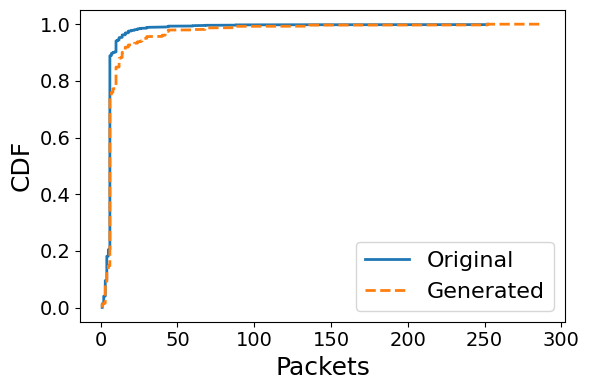

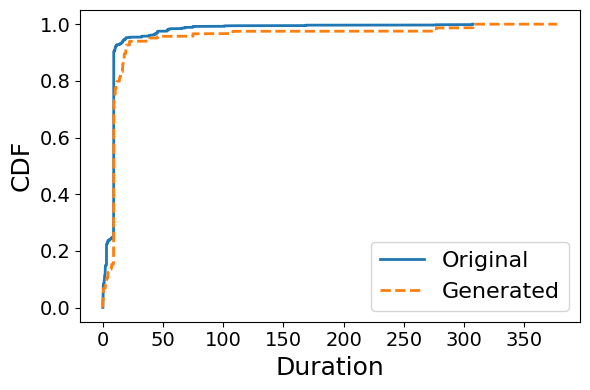

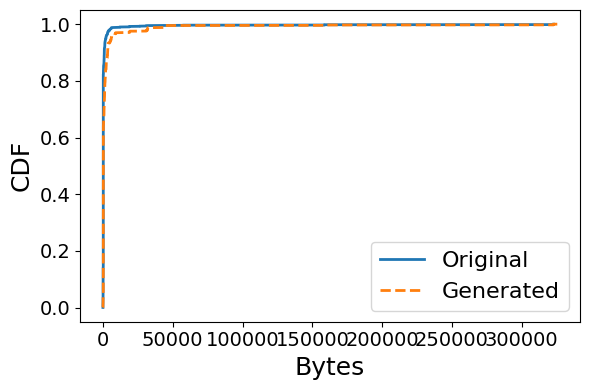

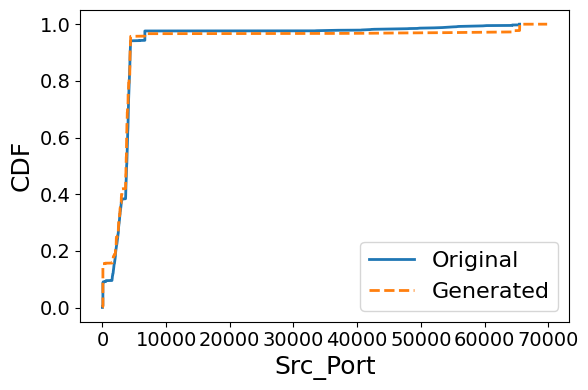

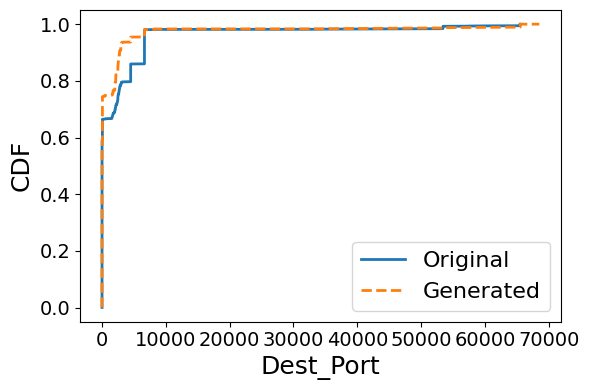

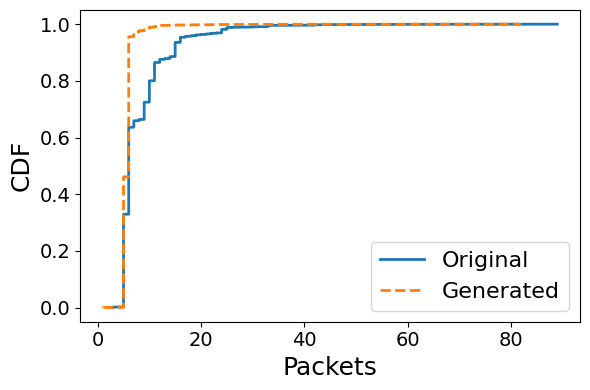

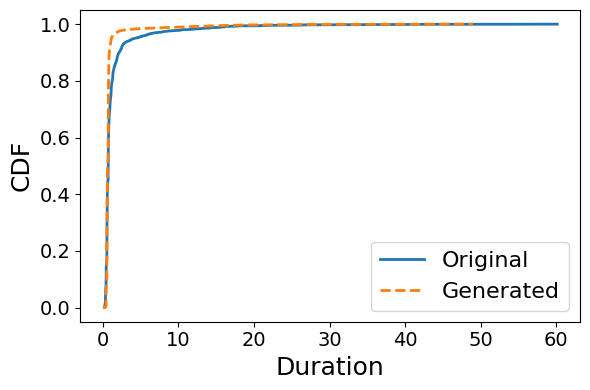

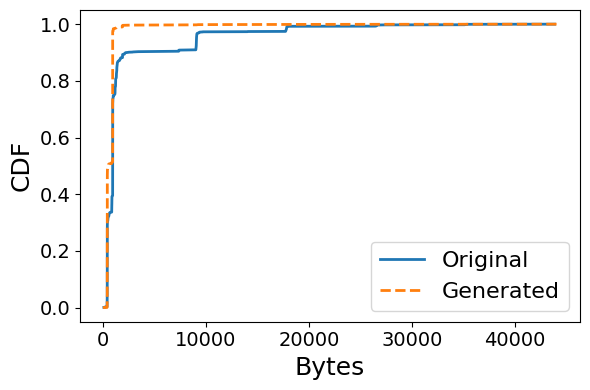

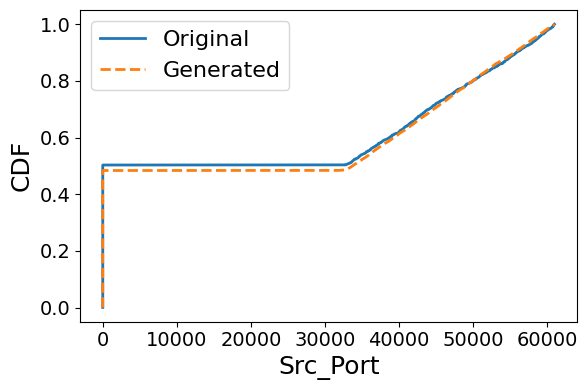

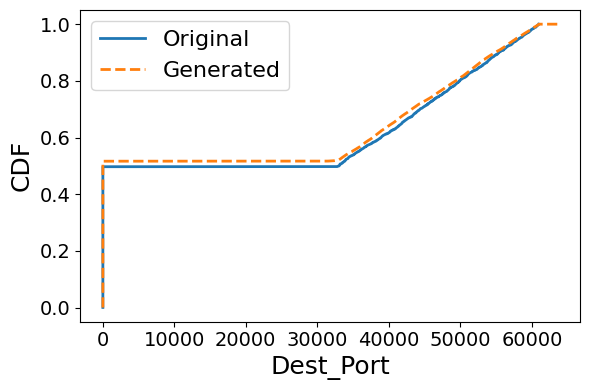

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cdfs(original_df, generated_df, features):
    for feature in features:
        orig_values = np.sort(original_df[feature].dropna())
        gen_values = np.sort(generated_df[feature].dropna())

        # Compute CDFs
        orig_cdf = np.arange(1, len(orig_values)+1) / len(orig_values)
        gen_cdf = np.arange(1, len(gen_values)+1) / len(gen_values)

        # Plot
        plt.figure(figsize=(6, 4))
        plt.plot(orig_values, orig_cdf, label='Original', linewidth=2)
        plt.plot(gen_values, gen_cdf, label='Generated', linewidth=2, linestyle='--')
        plt.xlabel(feature, fontsize=18)
        plt.ylabel("CDF",fontsize=18)
        plt.legend()
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=16)

        plt.tight_layout()
        plt.show()
plot_cdfs(botnet_orig, botnet_gen, selected_features)
plot_cdfs(spam_orig, spam_gen, selected_features)

W2 distance

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def compute_scaled_wasserstein_distances(df1, df2, features):
    scaler = MinMaxScaler()
    distances = {}

    for feature in features:

        combined = pd.concat([df1[feature], df2[feature]]).values.reshape(-1, 1)
        scaled = scaler.fit_transform(combined).flatten()

        split = len(df1[feature])
        scaled1 = scaled[:split]
        scaled2 = scaled[split:]

        distances[feature] = wasserstein_distance(scaled1, scaled2)

    return distances

w_scaled_botnet = compute_scaled_wasserstein_distances(botnet_orig, botnet_gen, selected_features)
w_scaled_spam = compute_scaled_wasserstein_distances(spam_orig, spam_gen, selected_features)

print("Wasserstein distances (Botnet):")
for k, v in w_scaled_botnet.items():
    print(f"{k}: {v:.4f}")

print("\nWasserstein distances (Spam):")
for k, v in w_scaled_spam.items():
    print(f"{k}: {v:.4f}")

Wasserstein distances (Botnet):
Packets: 0.0107
Duration: 0.0207
Bytes: 0.0043
Src_Port: 0.0144
Dest_Port: 0.0120

Wasserstein distances (Spam):
Packets: 0.0285
Duration: 0.0090
Bytes: 0.0274
Src_Port: 0.0147
Dest_Port: 0.0167


Violin plot

<ipython-input-45-52d531186ad0>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_combined, palette='Set2')


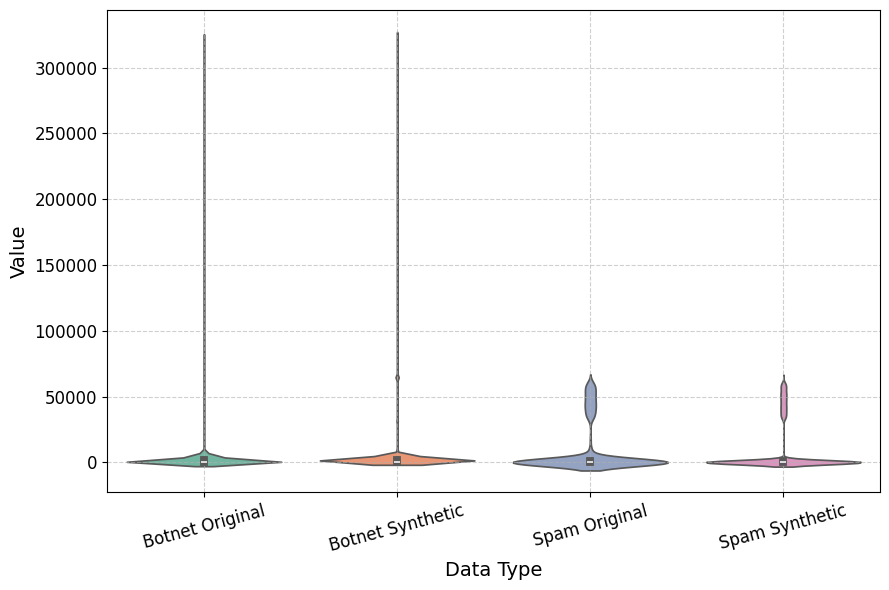

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def combined_violin_plot(botnet_orig, botnet_gen, spam_orig, spam_gen, features):
    data = []
    labels = []
    for label, df in zip(
        ['Botnet Original', 'Botnet Synthetic', 'Spam Original', 'Spam Synthetic'],
        [botnet_orig, botnet_gen, spam_orig, spam_gen]
    ):
        for feature in features:
            data.extend(df[feature].dropna().values)
            labels.extend([label] * df[feature].dropna().shape[0])
    df_combined = pd.DataFrame({'Value': data, 'Type': labels})
    plt.figure(figsize=(9, 6))
    sns.violinplot(x='Type', y='Value', data=df_combined, palette='Set2')
    plt.ylabel("Value", fontsize=14)
    plt.xlabel("Data Type", fontsize=14)
    plt.xticks(rotation=15, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']
combined_violin_plot(botnet_orig, botnet_gen, spam_orig, spam_gen, selected_features)


Heatmap

Plotting Spam - Non-Augmented Data Heatmap


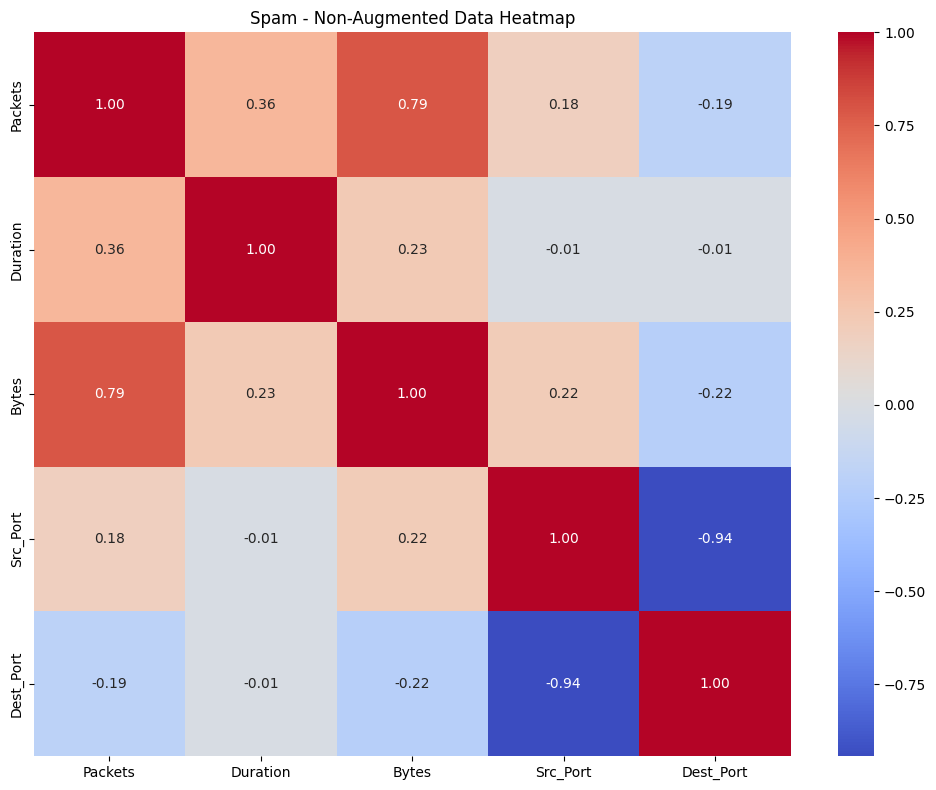

Plotting Spam - Augmented Data Heatmap


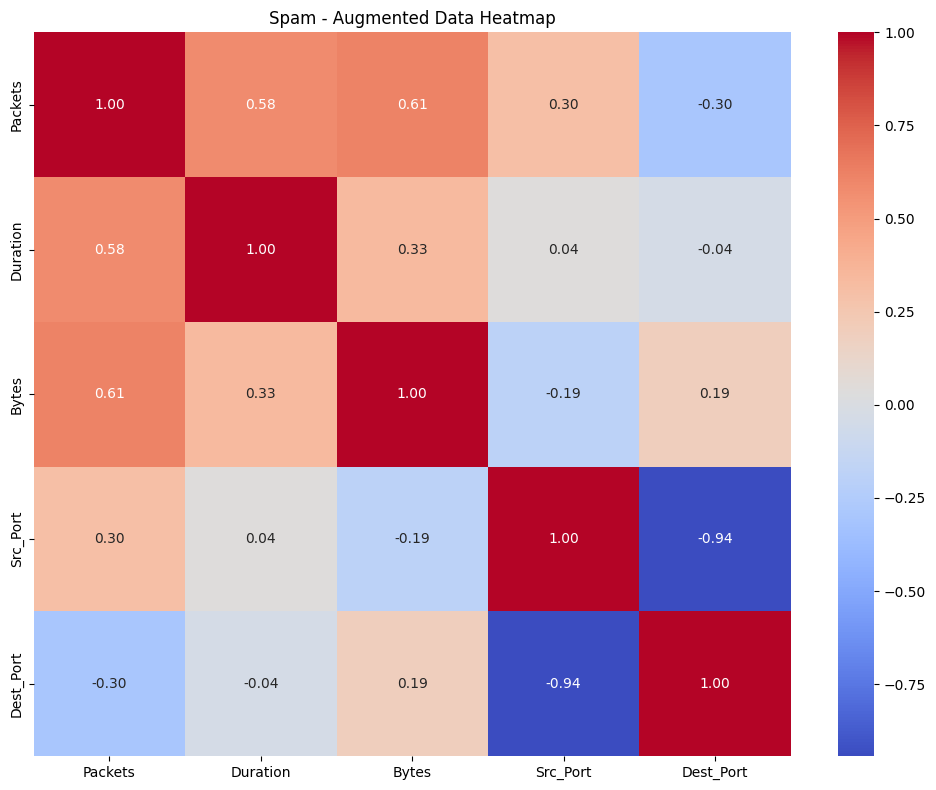

Plotting Botnet - Non-Augmented Data Heatmap


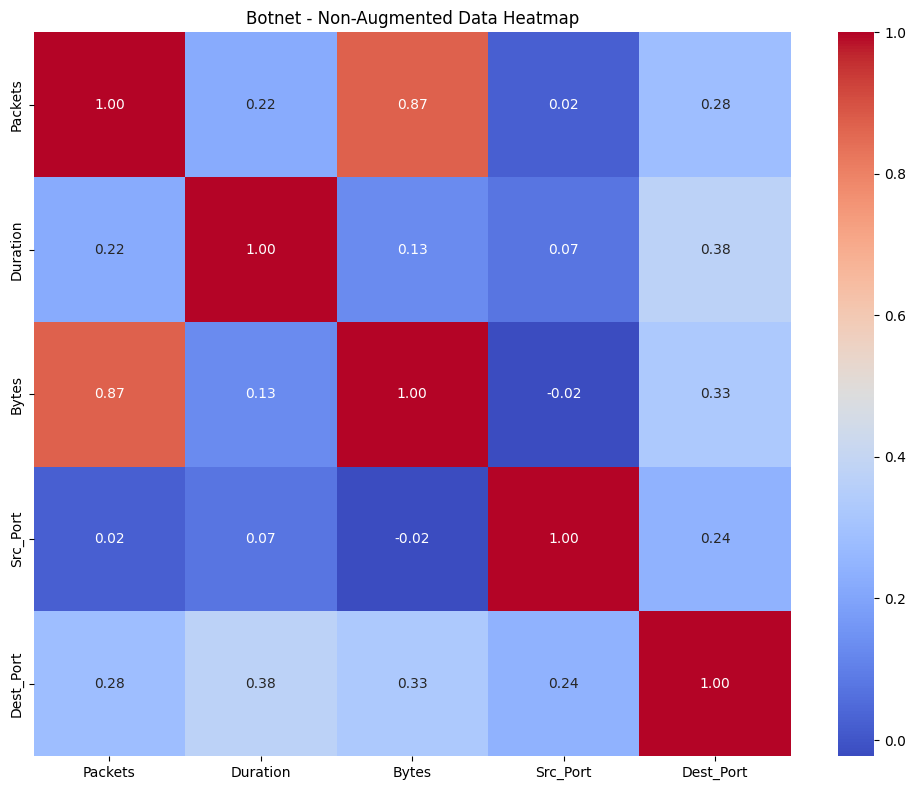

Plotting Botnet - Augmented Data Heatmap


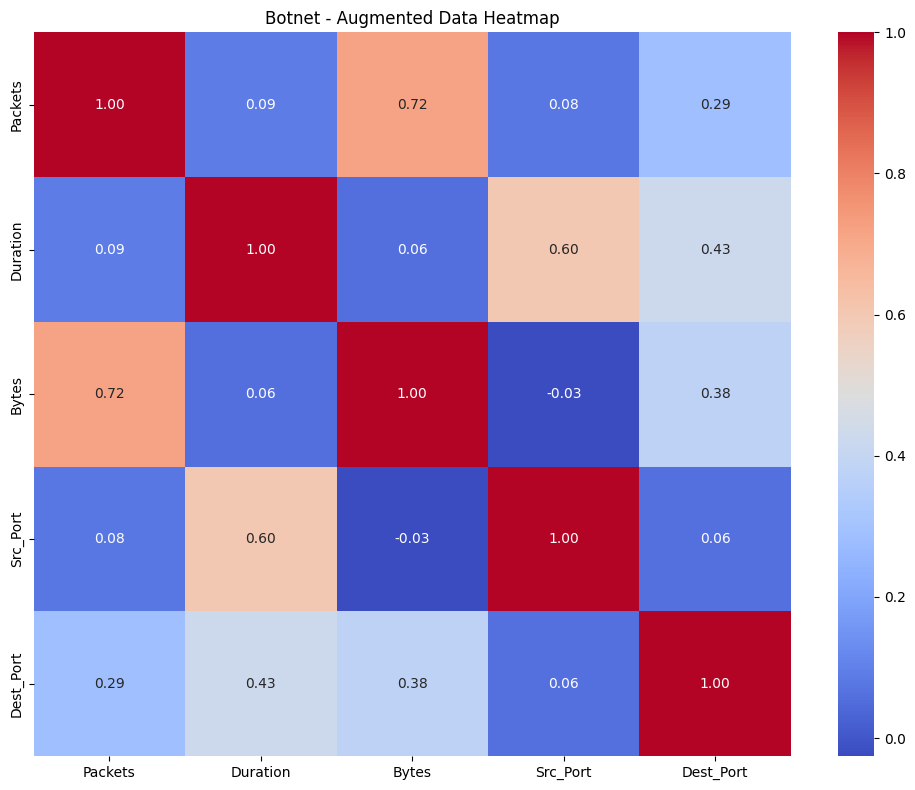

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data, title):
    plt.figure(figsize=(10, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()


print("Plotting Spam - Non-Augmented Data Heatmap")
plot_heatmap(spam_orig[selected_features], 'Spam - Non-Augmented Data Heatmap')
print("Plotting Spam - Augmented Data Heatmap")
plot_heatmap(spam_gen[selected_features], 'Spam - Augmented Data Heatmap')
print("Plotting Botnet - Non-Augmented Data Heatmap")
plot_heatmap(botnet_orig[selected_features], 'Botnet - Non-Augmented Data Heatmap')
print("Plotting Botnet - Augmented Data Heatmap")
plot_heatmap(botnet_gen[selected_features], 'Botnet - Augmented Data Heatmap')


pMSE

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

def compute_pmse(original_df, synthetic_df, features=None, test_size=0.3, random_state=42):
    if features is None:
        features = list(set(original_df.columns) & set(synthetic_df.columns))
        features = [f for f in features if pd.api.types.is_numeric_dtype(original_df[f])]

    original_df = original_df[features].copy()
    synthetic_df = synthetic_df[features].copy()
    original_df['label'] = 0
    synthetic_df['label'] = 1
    combined = pd.concat([original_df, synthetic_df], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
    X = combined[features]
    y = combined['label']
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Logistic regression Classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    p_hat = clf.predict_proba(X_test)[:, 1]
    # pMSE Computation
    pmse = np.mean((p_hat - 0.5) ** 2)
    return pmse

pmse_botnet = compute_pmse(botnet_orig, botnet_gen)
pmse_spam = compute_pmse(spam_orig, spam_gen)

print(f"pMSE Botnet: {pmse_botnet:.4f}")
print(f"pMSE Spam: {pmse_spam:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pMSE Botnet: 0.2160
pMSE Spam: 0.2178


Similarity calculation

Mahalanobis distance

       Duration  Src_Port  Dest_Port  Protocol  TOS  Packets  Bytes  U  A  P  \
0         9.026      4305         25         6    0        6    288  0  0  0   
2         9.013      3792         25         6    0        6    288  0  0  0   
3         5.569        80       2966         6    0        3    928  0  1  1   
4         9.013      3948         25         6    0        6    288  0  0  0   
5        10.320      4188         25         6    0        6    288  0  0  0   
...         ...       ...        ...       ...  ...      ...    ... .. .. ..   
52494     9.012      4352         25         6    0        6    288  0  0  0   
52495     9.013      3694         25         6    0        6    288  0  0  0   
52496     9.018      3785         25         6    0        6    288  0  0  0   
52497     9.037      4312         25         6    0        6    288  0  0  0   
52499     8.830      4403         25         6    0        6    288  0  0  0   

       R  S  F  Class  
0      0  1  0 

(array([3.1285e+04, 1.7700e+02, 2.9210e+03, 1.6450e+03, 1.0203e+04,
        1.5920e+03, 9.7500e+02, 3.3100e+02, 1.4700e+02, 6.6000e+01,
        7.2300e+02, 1.2400e+02, 7.2000e+01, 1.1900e+02, 2.2100e+02,
        3.6700e+02, 2.0900e+02, 1.7000e+01, 4.2400e+02, 4.8300e+02,
        8.0000e+00, 1.4000e+02, 2.0800e+02, 9.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 3.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([ 0.61866116,  1.55075153,  2.48284191,  3.41493229,  4.34702266,
         5.27911304,  6.21120342,  7.14329379,  8.07538417,  9.00747455,
         9.93956492, 10.8716553 , 11.80374568, 12.73583605, 13.66792643,
        14.6000168 , 15.53210718, 16.46419756, 17.39628793, 18.32837831,
        19.26046869, 20.19

Text(0.5, 1.0, 'Mahalanobis Distance of Synthetic Samples')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Frequency')

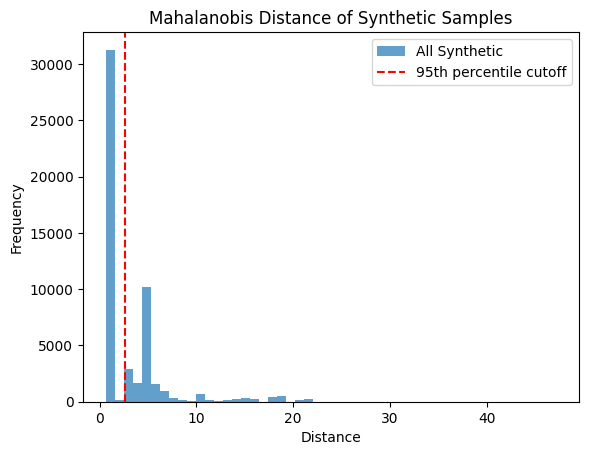

In [ ]:
from scipy.spatial import distance
import numpy as np

from sklearn.preprocessing import StandardScaler

#scale
scaler = StandardScaler()
X_real_botnet_scaled = scaler.fit_transform(botnet_orig)
X_synth_botnet_scaled = scaler.transform(botnet_gen)

X_real_spam_scaled = scaler.fit_transform(spam_orig)
X_synth_spam_scaled = scaler.transform(spam_gen)

#botnet
mu = np.mean(X_real_botnet_scaled, axis=0)
cov = np.cov(X_real_botnet_scaled, rowvar=False)
inv_covmat = np.linalg.pinv(cov)

distances = [distance.mahalanobis(x, mu, inv_covmat) for x in X_synth_botnet_scaled]

#spam
mu = np.mean(X_real_spam_scaled, axis=0)
cov = np.cov(X_real_spam_scaled, rowvar=False)
inv_covmat = np.linalg.pinv(cov)

distances_spam = [distance.mahalanobis(x, mu, inv_covmat) for x in X_synth_spam_scaled]

threshold = np.percentile(distances, 95)
filtered_X_botnet_synth = botnet_gen[np.array(distances) < threshold]

threshold = np.percentile(distances_spam, 95)
filtered_X_spam_synth = spam_gen[np.array(distances_spam) < threshold]
print(filtered_X_botnet_synth)
print("Original synthetic samples botnet:", len(X_synth_botnet_scaled))
print("After filtering:", filtered_X_botnet_synth.shape[0])
print("Removed samples:", len(X_synth_botnet_scaled) - filtered_X_botnet_synth.shape[0])

print("Original synthetic samples spam:", len(X_synth_spam_scaled))
print("After filtering:", filtered_X_spam_synth.shape[0])
print("Removed samples:", len(X_synth_spam_scaled) - filtered_X_spam_synth.shape[0])


import matplotlib.pyplot as plt

plt.hist(distances, bins=50, alpha=0.7, label='All Synthetic')
plt.axvline(threshold, color='red', linestyle='--', label='95th percentile cutoff')
plt.title("Mahalanobis Distance of Synthetic Samples")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np


X = dfjuly.drop(columns=['Class'])
y = dfjuly['Class']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


filtered_X_botnet_synth = filtered_X_botnet_synth.drop(columns='Class', errors='ignore')
filtered_X_spam_synth = filtered_X_spam_synth.drop(columns='Class', errors='ignore')

# augment synthetic samples
X_train = pd.concat([X_train_orig, filtered_X_botnet_synth, filtered_X_spam_synth], ignore_index=True)

y_train = pd.concat([
    y_train_orig,
    pd.Series([2] * len(filtered_X_botnet_synth)),
    pd.Series([4] * len(filtered_X_spam_synth))
], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

#shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

#scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Label distribution in training set:\n", y_train.value_counts())

mlp_classifier.fit(X_train, y_train)
y_pred_mlp = mlp_classifier.predict(X_test)
class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan44', 4: 'Spam'}
y_test_class = y_test.map(class_labels)
y_pred_mlp_class = pd.Series(y_pred_mlp).map(class_labels)

print("=== MLP Classification Report ===")
print(classification_report(y_test_class, y_pred_mlp_class))

conf_matrix = confusion_matrix(y_test_class, y_pred_mlp_class)
print("\nConfusion Matrix:\n", conf_matrix)

fpr_dict = {}
fnr_dict = {}
for i in range(len(conf_matrix)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_proba = mlp_classifier.predict_proba(X_test)

from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


NameError: name 'dfjuly' is not defined

In [ ]:
filtered_X_botnet_md= filtered_X_botnet_synth
filtered_X_spam_md = filtered_X_spam_synth

In [ ]:
filtered_X_botnet_synth.to_csv('Reverse_LLM_MD_botnet_July.csv', index=False)
filtered_X_spam_synth.to_csv('Reverse_LLM_MD_spam_July.csv', index=False)

In [ ]:
print(len(X_real_spam_scaled))

NameError: name 'X_real_spam_scaled' is not defined

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


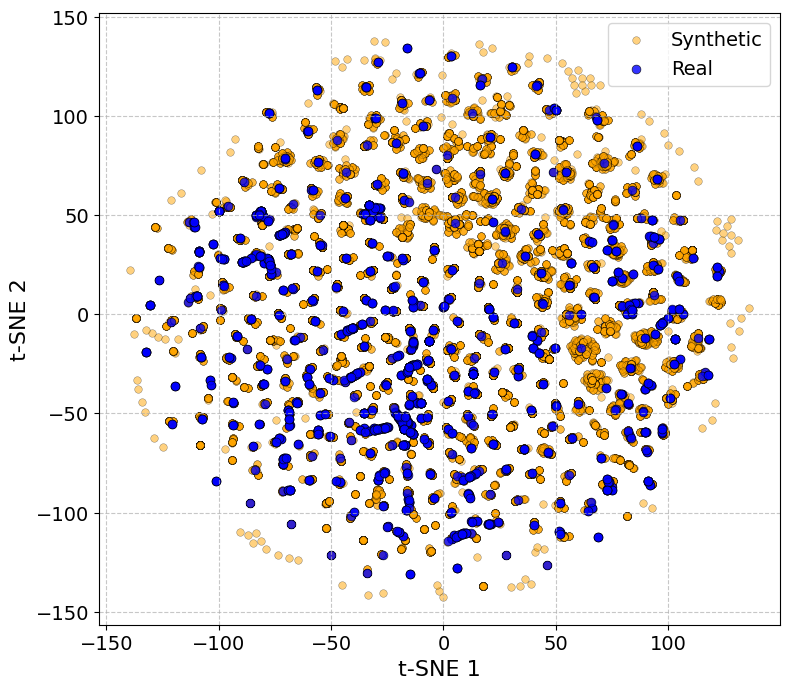

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


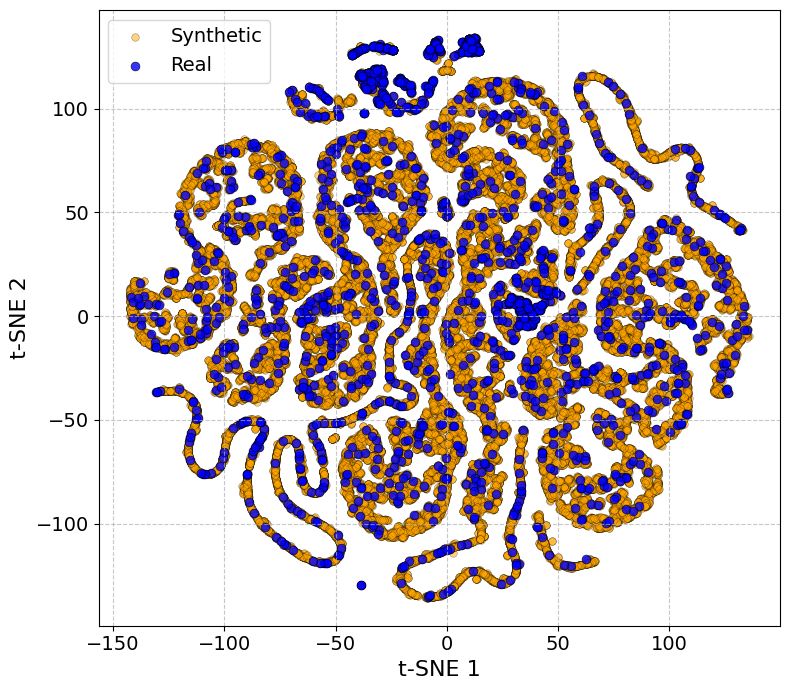

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(real_scaled, synth_scaled, title):
    combined = np.vstack([real_scaled, synth_scaled])
    labels = np.array([0] * len(real_scaled) + [1] * len(synth_scaled))

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_results = tsne.fit_transform(combined)

    plt.figure(figsize=(8, 7))

    # Synthetic
    plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1],
                c='orange', label='Synthetic', alpha=0.5, s=30,
                edgecolors='k', linewidths=0.3)

    # Real
    plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1],
                c='blue', label='Real', alpha=0.8, s=40,
                edgecolors='k', linewidths=0.5)

    plt.legend(fontsize=14)
    plt.xlabel("t-SNE 1", fontsize=16)
    plt.ylabel("t-SNE 2", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)  # Tick labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_tsne(X_real_botnet_scaled, X_synth_botnet_scaled, "Botnet")
plot_tsne(X_real_spam_scaled, X_synth_spam_scaled, "Spam")


One class SVM

In [ ]:
from sklearn.svm import OneClassSVM


ocsvm_botnet = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')  # nu=0.05 allows ~5% outliers
ocsvm_botnet.fit(X_real_botnet_scaled)
scores_botnet = ocsvm_botnet.predict(X_synth_botnet_scaled)  # -1 for outlier, 1 for inlier

filtered_ocsvm_botnet = botnet_gen[np.array(scores_botnet) == 1]

ocsvm_spam = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm_spam.fit(X_real_spam_scaled)
scores_spam = ocsvm_spam.predict(X_synth_spam_scaled)

filtered_ocsvm_spam = spam_gen[np.array(scores_spam) == 1]


print("Botnet - OC-SVM accepted:", filtered_ocsvm_botnet.shape[0])
print("Spam - OC-SVM accepted:", filtered_ocsvm_spam.shape[0])


OneClassSVM(nu=0.05)

OneClassSVM(nu=0.05)

Botnet - OC-SVM accepted: 47607
Spam - OC-SVM accepted: 51118


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np


X = dforiginal.drop(columns=['Class'])
y = dforiginal['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_ocsvm_botnet = filtered_ocsvm_botnet.drop(columns='Class', errors='ignore')
filtered_ocsvm_spam = filtered_ocsvm_spam.drop(columns='Class', errors='ignore')
X_train = pd.concat([X_train_orig, filtered_ocsvm_botnet, filtered_ocsvm_spam], ignore_index=True)
y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_ocsvm_botnet)), pd.Series([4] * len(filtered_ocsvm_spam))], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_train, y_train = shuffle(X_train, y_train, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred = mlp_classifier.predict(X_test_scaled)


class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan44', 4: 'Spam'}

print("=== MLP Classification Report (OC-SVM filtered data) ===")
y_test_class = y_test.map(class_labels)
y_pred_class = pd.Series(y_pred).map(class_labels)
print(classification_report(y_test_class, y_pred_class))

cm = confusion_matrix(y_test_class, y_pred_class)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=[class_labels[i] for i in range(len(class_labels))], columns=[class_labels[i] for i in range(len(class_labels))]))


fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_proba = mlp_classifier.predict_proba(X_test_scaled)

from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


MLPClassifier(random_state=42)

=== MLP Classification Report (OC-SVM filtered data) ===
              precision    recall  f1-score   support

      Benign       0.99      0.95      0.97      9000
      Botnet       0.80      0.95      0.87       600
         DoS       1.00      1.00      1.00      5250
        Scan       0.99      1.00      0.99      5250
        Spam       0.71      0.93      0.81       600

    accuracy                           0.97     20700
   macro avg       0.90      0.97      0.93     20700
weighted avg       0.98      0.97      0.98     20700


Confusion Matrix:
        Benign  DoS  Botnet  Scan  Spam
Benign    8555  140       3    77   225
DoS         27  573       0     0     0
Botnet       0    0    5250     0     0
Scan         7    0       0  5243     0
Spam        40    0       0     0   560

False Negative Rate (FNR) per class:
Class Benign: 0.0494
Class DoS: 0.0450
Class Botnet: 0.0000
Class Scan: 0.0013
Class Spam: 0.0667

False Positive Rate (FPR) per class:
Class Benign: 0.0063


In [ ]:
filtered_ocsvm_botnet.to_csv('Reverse_LLM_OCSVM_botnet_July.csv', index=False)
filtered_ocsvm_spam.to_csv('Reverse_LLM_OCSVM_spam_July.csv', index=False)

k-nearest neighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

knn_botnet = NearestNeighbors(n_neighbors=5)
knn_botnet.fit(X_real_botnet_scaled)
distances_knn_botnet, _ = knn_botnet.kneighbors(X_synth_botnet_scaled)
avg_knn_dist_botnet = distances_knn_botnet.mean(axis=1)
threshold_knn_botnet = np.percentile(avg_knn_dist_botnet, 95)
filtered_knn_botnet = botnet_gen[np.array(avg_knn_dist_botnet) < threshold_knn_botnet]

knn_spam = NearestNeighbors(n_neighbors=5)
knn_spam.fit(X_real_spam_scaled)
distances_knn_spam, _ = knn_spam.kneighbors(X_synth_spam_scaled)
avg_knn_dist_spam = distances_knn_spam.mean(axis=1)
threshold_knn_spam = np.percentile(avg_knn_dist_spam, 95)
filtered_knn_spam = spam_gen[np.array(avg_knn_dist_spam) < threshold_knn_spam]



print("Botnet - kNN accepted:", filtered_knn_botnet.shape[0])
print("Spam - kNN accepted:", filtered_knn_spam.shape[0])


NearestNeighbors()

NearestNeighbors()

Botnet - kNN accepted: 49702
Spam - kNN accepted: 49875


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)
import numpy as np
import pandas as pd

X = dforiginal.drop(columns=['Class'])
y = dforiginal['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_knn_botnet = filtered_knn_botnet.drop(columns='Class', errors='ignore')
filtered_knn_spam = filtered_knn_spam.drop(columns='Class', errors='ignore')

X_train = pd.concat([X_train_orig, filtered_knn_botnet, filtered_knn_spam], ignore_index=True)
y_train = pd.concat([y_train_orig,
    pd.Series([2] * len(filtered_knn_botnet)),
    pd.Series([4] * len(filtered_knn_spam)),
], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_train, y_train = shuffle(X_train, y_train, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_classifier.predict(X_test_scaled)
y_proba = mlp_classifier.predict_proba(X_test_scaled)

class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

print("=== MLP Classification Report ===")
y_test_class = y_test.map(class_labels)
y_pred_class = pd.Series(y_pred_mlp).map(class_labels)
print(classification_report(y_test_class, y_pred_class))

cm = confusion_matrix(y_test_class, y_pred_class)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=[class_labels[i] for i in range(len(class_labels))], columns=[class_labels[i] for i in range(len(class_labels))]))

fpr_dict = {}
fnr_dict = {}

for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_test_bin = label_binarize(y_test, classes=np.unique(y))
prauc_dict = {}
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


MLPClassifier(max_iter=300, random_state=42)

=== MLP Classification Report ===
              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97      9000
      Botnet       0.79      0.96      0.87       600
         DoS       1.00      1.00      1.00      5250
        Scan       0.99      1.00      0.99      5250
        Spam       0.78      0.87      0.82       600

    accuracy                           0.98     20700
   macro avg       0.91      0.96      0.93     20700
weighted avg       0.98      0.98      0.98     20700


Confusion Matrix:
        Benign  DoS  Botnet  Scan  Spam
Benign    8616  155       3    77   149
DoS         24  576       0     0     0
Botnet       0    0    5250     0     0
Scan         8    0       0  5242     0
Spam        77    0       0     0   523

False Negative Rate (FNR) per class:
Class Benign: 0.0427
Class DoS: 0.0400
Class Botnet: 0.0000
Class Scan: 0.0015
Class Spam: 0.1283

False Positive Rate (FPR) per class:
Class Benign: 0.0093
Class DoS: 0.0077
Class

In [ ]:
#convert to csv
filtered_knn_botnet.to_csv('Reverse_LLM_knn_botnet_July.csv', index=False)
filtered_knn_spam.to_csv('Reverse_LLM_knn_spam_July.csv', index=False)

Cosine similarity

Original synthetic samples botnet: 52500
After filtering: 51855
Removed samples: 645
Original synthetic samples spam: 52500
After filtering: 52484
Removed samples: 16


(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.8000e+01, 4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+01,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 7.0000e+00, 1.5000e+01, 1.8000e+01,
        1.2000e+01, 8.0000e+00, 8.0000e+00, 5.0000e+00, 8.0000e+00,
        9.0000e+00, 1.7000e+01, 1.8000e+01, 2.0000e+01, 3.7000e+01,
        2.1000e+01, 2.0000e+01, 3.1500e+02, 4.5000e+01, 1.9000e+01,
        3.7000e+01, 1.0200e+02, 8.9000e+01, 5.2100e+02, 5.1087e+04]),
 array([0.57974657, 0.58815164, 0.5965567 , 0.60496177, 0.61336684,
        0.62177191, 0.63017698, 0.63858205, 0.64698712, 0.65539219,
        0.66379725, 0.67220232, 0.68060739, 0.68901246, 0.69741753,
        0.7058226 , 0.71422767, 0.72263273, 0.7310378 , 0.73944287,
        0.74784794, 0.75625301, 0.76465808, 0.

Text(0.5, 1.0, 'Cosine Similarity of Synthetic Botnet Samples')

Text(0.5, 0, 'Cosine Similarity')

Text(0, 0.5, 'Frequency')

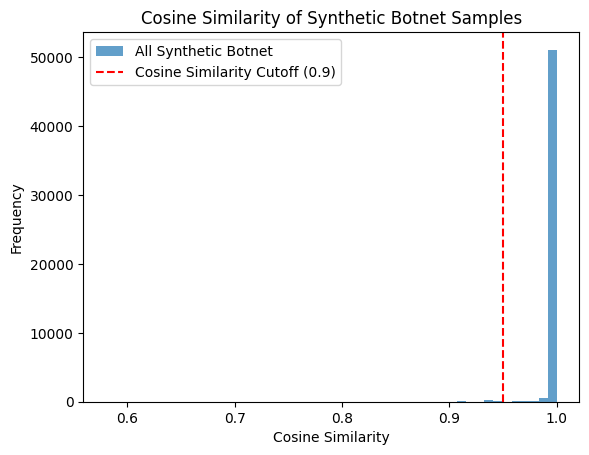

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        5.0000e+00, 2.7000e+01, 5.5000e+01, 1.8300e+02, 5.2219e+04]),
 array([0.36896913, 0.38158975, 0.39421036, 0.40683098, 0.4194516 ,
        0.43207222, 0.44469283, 0.45731345, 0.46993407, 0.48255469,
        0.4951753 , 0.50779592, 0.52041654, 0.53303715, 0.54565777,
        0.55827839, 0.57089901, 0.58351962, 0.59614024, 0.60876086,
        0.62138148, 0.63400209, 0.64662271, 0.

Text(0.5, 1.0, 'Cosine Similarity of Synthetic Spam Samples')

Text(0.5, 0, 'Cosine Similarity')

Text(0, 0.5, 'Frequency')

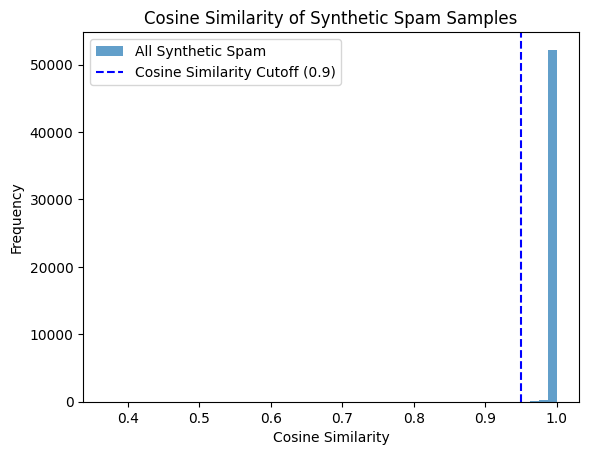

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_real_botnet_scaled = scaler.fit_transform(botnet_orig)
X_synth_botnet_scaled = scaler.transform(botnet_gen)

X_real_spam_scaled = scaler.fit_transform(spam_orig)
X_synth_spam_scaled = scaler.transform(spam_gen)

cos_sim_botnet = cosine_similarity(X_synth_botnet_scaled, X_real_botnet_scaled).max(axis=1)
cos_sim_spam = cosine_similarity(X_synth_spam_scaled, X_real_spam_scaled).max(axis=1)

threshold_botnet = 0.95
filtered_X_botnet_synth = botnet_gen[cos_sim_botnet > threshold_botnet]
threshold_spam = 0.95
filtered_X_spam_synth = spam_gen[cos_sim_spam > threshold_spam]
print("Original synthetic samples botnet:", len(X_synth_botnet_scaled))
print("After filtering:", filtered_X_botnet_synth.shape[0])
print("Removed samples:", len(X_synth_botnet_scaled) - filtered_X_botnet_synth.shape[0])

print("Original synthetic samples spam:", len(X_synth_spam_scaled))
print("After filtering:", filtered_X_spam_synth.shape[0])
print("Removed samples:", len(X_synth_spam_scaled) - filtered_X_spam_synth.shape[0])

plt.hist(cos_sim_botnet, bins=50, alpha=0.7, label='All Synthetic Botnet')
plt.axvline(threshold_botnet, color='red', linestyle='--', label='Cosine Similarity Cutoff (0.9)')
plt.title("Cosine Similarity of Synthetic Botnet Samples")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.hist(cos_sim_spam, bins=50, alpha=0.7, label='All Synthetic Spam')
plt.axvline(threshold_spam, color='blue', linestyle='--', label='Cosine Similarity Cutoff (0.9)')
plt.title("Cosine Similarity of Synthetic Spam Samples")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

class_names = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

X = dforiginal.drop(columns=['Class'])
y = dforiginal['Class']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_X_botnet_synth = filtered_X_botnet_synth.drop(columns='Class', errors='ignore')
filtered_X_spam_synth = filtered_X_spam_synth.drop(columns='Class', errors='ignore')

X_train = pd.concat([X_train_orig, filtered_X_botnet_synth], ignore_index=True)
X_train = pd.concat([X_train, filtered_X_spam_synth], ignore_index=True)


y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_X_botnet_synth))], ignore_index=True)
y_train = pd.concat([y_train, pd.Series([4] * len(filtered_X_spam_synth))], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test = X_test[X_train.columns]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Label distribution in training set:\n", y_train.value_counts())

mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_classifier.predict(X_test_scaled)
print("=== MLP Classification Report ===")
print(classification_report(y_test, y_pred_mlp))

cm = confusion_matrix(y_test, y_pred_mlp)
print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, index=[class_names[i] for i in range(len(class_names))],
                     columns=[class_names[i] for i in range(len(class_names))])
print(cm_df)
fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"{class_names[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"{class_names[k]}: {v:.4f}")

y_proba = mlp_classifier.predict_proba(X_test_scaled)

classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[classes[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"{class_names[k]}: {v:.4f}")


Label distribution in training set:
 4    53884
2    53255
0    21000
3    12250
1    12250
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

=== MLP Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9000
           1       1.00      1.00      1.00      5250
           2       0.78      0.96      0.87       600
           3       0.99      1.00      0.99      5250
           4       0.59      0.98      0.74       600

    accuracy                           0.97     20700
   macro avg       0.87      0.97      0.91     20700
weighted avg       0.98      0.97      0.97     20700


Confusion Matrix:
        Benign   DoS  Botnet  Scan  Spam
Benign    8350     3     159    79   409
DoS          0  5250       0     0     0
Botnet      21     0     579     0     0
Scan         7     0       0  5243     0
Spam        10     0       0     0   590

False Negative Rate (FNR) per class:
Benign: 0.0722
DoS: 0.0000
Botnet: 0.0350
Scan: 0.0013
Spam: 0.0167

False Positive Rate (FPR) per class:
Benign: 0.0032
DoS: 0.0002
Botnet: 0.0079
Scan: 0.0051
Spam: 0.0203


In [ ]:
filtered_X_botnet_synth.to_csv('Reverse_LLM_cosine_botnet_July.csv', index=False)
filtered_X_spam_synth.to_csv('Reverse_LLM_cosine_July.csv', index=False)